/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode: 0, total reward: -200.0, epsilon: 0.3
Episode: 1, total reward: -200.0, epsilon: 0.297
Episode: 2, total reward: -200.0, epsilon: 0.29402999999999996
Episode: 3, total reward: -200.0, epsilon: 0.29108969999999995
Episode: 4, total reward: -200.0, epsilon: 0.28817880299999993
Episode: 5, total reward: -200.0, epsilon: 0.28529701496999993
Episode: 6, total reward: -200.0, epsilon: 0.28244404482029994
Episode: 7, total reward: -200.0, epsilon: 0.27961960437209693
Episode: 8, total reward: -200.0, epsilon: 0.276823408328376
Episode: 9, total reward: -200.0, epsilon: 0.27405517424509224
Episode: 10, total reward: -200.0, epsilon: 0.2713146225026413
Episode: 11, total reward: -200.0, epsilon: 0.2686014762776149
Episode: 12, total reward: -200.0, epsilon: 0.26591546151483875
Episode: 13, total reward: -200.0, epsilon: 0.2632563068996904
Episode: 14, total reward: -200.0, epsilon: 0.2606237438306935
Episode: 15, total reward: -200.0, epsilon: 0.2580175063923865
Episode: 16, total rewa

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Episode: 951, total reward: -190.0, epsilon: 0.01


/usr/local/lib/python3.10/dist-packages/imageio/plugins/pillow.py:390: DeprecationWarning: The keyword `fps` is no longer supported. Use `duration`(in ms) instead, e.g. `fps=50` == `duration=20` (1000 * 1/50).
  warnings.warn(


Episode: 952, total reward: -200.0, epsilon: 0.01
Episode: 953, total reward: -200.0, epsilon: 0.01
Episode: 954, total reward: -175.0, epsilon: 0.01
Episode: 955, total reward: -173.0, epsilon: 0.01
Episode: 956, total reward: -178.0, epsilon: 0.01
Episode: 957, total reward: -168.0, epsilon: 0.01
Episode: 958, total reward: -172.0, epsilon: 0.01
Episode: 959, total reward: -180.0, epsilon: 0.01
Episode: 960, total reward: -170.0, epsilon: 0.01
Episode: 961, total reward: -183.0, epsilon: 0.01
Episode: 962, total reward: -166.0, epsilon: 0.01
Episode: 963, total reward: -101.0, epsilon: 0.01
Episode: 964, total reward: -170.0, epsilon: 0.01
Episode: 965, total reward: -172.0, epsilon: 0.01
Episode: 966, total reward: -107.0, epsilon: 0.01
Episode: 967, total reward: -169.0, epsilon: 0.01
Episode: 968, total reward: -200.0, epsilon: 0.01
Episode: 969, total reward: -117.0, epsilon: 0.01
Episode: 970, total reward: -113.0, epsilon: 0.01
Episode: 971, total reward: -173.0, epsilon: 0.01


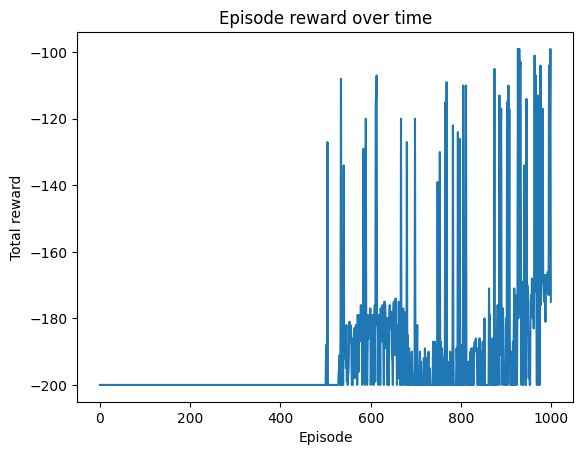

In [ ]:
from collections import deque

import gym
import torch

from torch.autograd import Variable
import random
import imageio
import pygame

env = gym.envs.make("MountainCar-v0")
env.reset(seed=1)


class DeepQNetwork:
    def __init__(self, n_state, n_action, n_hidden, lr):
        self.loss = torch.nn.MSELoss()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(n_state, n_hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(n_hidden, n_action)
        )
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)

    def update(self, s, y):
        y_pred = self.model(torch.Tensor(s))
        loss = self.loss(y_pred, Variable(torch.Tensor(y)))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def predict(self, s):
        with torch.no_grad():
            return self.model(torch.Tensor(s))

    def prepare_experience_to_replay(self, memory, replay_size, gamma):
        if len(memory) < replay_size:
            return

        replay_data = random.sample(memory, replay_size)
        states = []
        td_targets = []
        for state, action, next_state, reward, is_done in replay_data:
            states.append(state)
            q_values = self.predict(state).tolist()
            if is_done:
                q_values[action] = reward
            else:
                q_values_next = self.predict(next_state)
                q_values[action] = reward + gamma * torch.max(q_values_next).item()

            td_targets.append(q_values)

        self.update(states, td_targets)


def gen_epsilon_greedy_policy(estimator, epsilon, n_action):
    def policy_function(state):
        if random.random() < epsilon:
            return random.randint(0, n_action - 1)
        else:
            q_values = estimator.predict(state)
            return torch.argmax(q_values).item()

    return policy_function


gamma = .9
epsilon = .3
epsilon_decay = .99
n_state = env.observation_space.shape[0]
n_action = env.action_space.n
n_hidden = 32
lr = 0.001
n_episode = 1000
total_reward_episode = [0] * n_episode
dqn = DeepQNetwork(n_state, n_action, n_hidden, lr)
memory = deque(maxlen=10000)
size = 20

for episode in range(n_episode):
    policy = gen_epsilon_greedy_policy(dqn, epsilon, n_action)
    state = env.reset()
    is_done = False
    frames = []
    is_render = episode > 950

    steps = 0
    while not is_done:
        steps += 1
        action = policy(state)
        next_state, reward, is_done, _ = env.step(action)
        total_reward_episode[episode] += reward

        if is_render:
            frames.append(env.render(mode='rgb_array'))

        modified_reward = next_state[0] + 0.5

        if next_state[0] >= 0.5:
            modified_reward += 100
        elif next_state[0] >= 0.25:
            modified_reward += 20
        elif next_state[0] >= 0.1:
            modified_reward += 10
        elif next_state[0] >= 0:
            modified_reward += 5

        memory.append((state, action, next_state, modified_reward, is_done))

        if is_done:
            break

        dqn.prepare_experience_to_replay(memory, size, gamma)
        state = next_state

    print('Episode: {}, total reward: {}, epsilon: {}'.format(episode, total_reward_episode[episode], epsilon))

    epsilon = max(epsilon * epsilon_decay, 0.01)

    if is_render:
        imageio.mimsave(f'./{episode}_{steps}.gif', frames, fps=40)

import matplotlib.pyplot as plt

plt.plot(total_reward_episode)
plt.title('Episode reward over time')
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.show()
